In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import fiona
import sklearn

In [2]:
#Upload the selection of glaciers i will use
selection = []

with open('/Users/francesco/Desktop/Thesis/Data/dataset_filtered' + '/selecao.txt', 'r') as f:
    for line in f:
        selection.append(int(line.strip()))

common_years = np.arange(2005,2017,1)

print('The shape of the selection is: ', np.shape(selection))

The shape of the selection is:  (128,)


In the following block I will extract informations about glaciers from the shp file

In [3]:
path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
regions = []
areas = []
lats = []
lons = []


shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])

for feature in shapefile:


    id = feature['properties']['id']
    name=feature['properties']['name']
    area=feature['properties']['area_fra']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']

    #Taking the info
    ids.append(id)
    Names.append(name)
    regions.append(region)
    areas.append(area)
    lats.append(lat)
    lons.append(lon)

#Creating the dataframe
df_region = pd.DataFrame(index=ids)
df_region ['id'] = ids
df_region ['Name'] = Names
df_region ['Region'] = regions
df_region ['Area'] = areas
df_region ['Latitude'] = lats
df_region ['Longitude'] = lons

#Selecting the region and sorting the dataframe
df_region = df_region[df_region['id'].isin(selection)]
df_region = df_region.sort_values(by=['id'])
#drop id column
df_region = df_region.drop(['id'], axis=1)


{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'float:24.15', 'mass_los16': 'float:24.15', 'mass_los17': 'floa

/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_10022/202537314.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


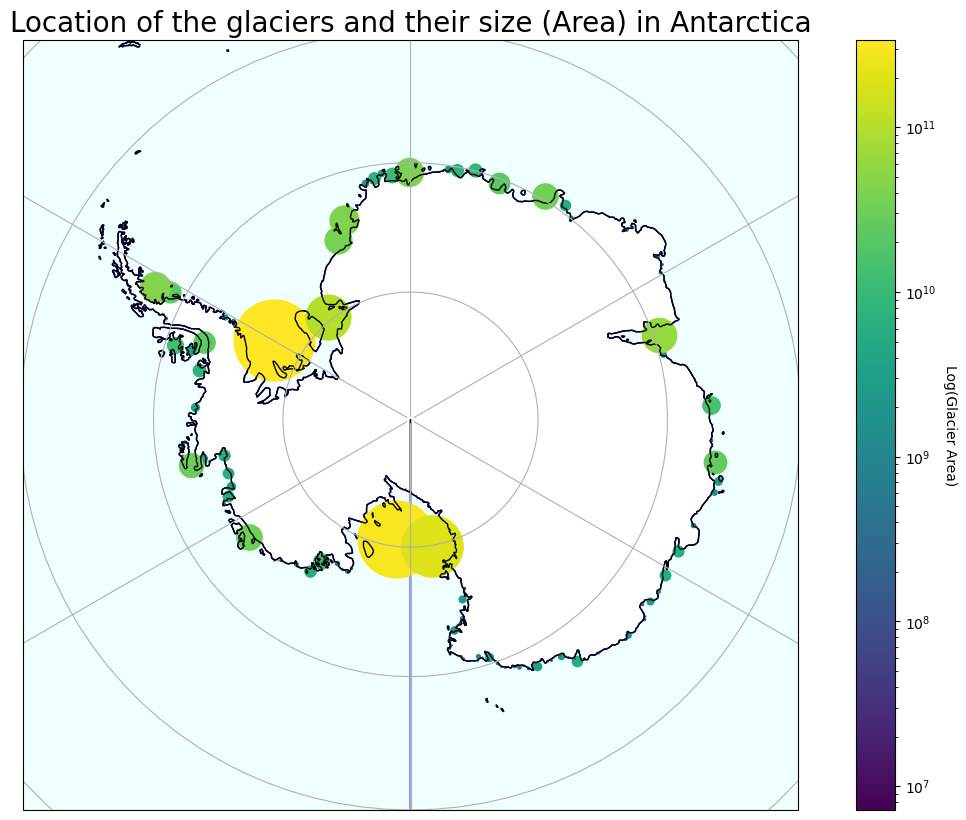

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import cartopy.feature


# Create a plot with a map of Antarctica
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add land color
ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, edgecolor='blue', facecolor='azure')


# Apply logarithm to 'Area' values and normalize for colormap
log_norm = mcolors.LogNorm(vmin=df_region['Area'].min(), vmax=df_region['Area'].max())
cmap = plt.get_cmap('viridis')  # Choose a colormap

for id in df_region.index:
    color = cmap(log_norm(df_region['Area'].loc[id]))
    ax.scatter(
        df_region['Longitude'].loc[id], df_region['Latitude'].loc[id],
        color=color, s=df_region.Area.loc[id] / 100000000, transform=ccrs.PlateCarree(), marker='o'
    )

# Add colorbar to the plot
sm = ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Log(Glacier Area)', rotation=270, labelpad=15)

plt.title('Location of the glaciers and their size (Area) in Antarctica', fontsize=20)
plt.show()


<font size="7">***Here i will calculate the block division for the point-sized glaciers***</font>

In [5]:
#Loading the dataset
dataset_directory = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/'

# Basal Melting
bm = pd.read_csv(dataset_directory + '/bm.csv', index_col=0)
bm = bm.sort_values(by=['id']) #sorting the glaciers by their index
bm = bm.loc[bm.index.isin(selection)] #selecting the glaciers, according to their index
bm = bm[common_years.astype(str)] #selecting the common years
bm = bm.sort_index() #sorting the glaciers by their index

#Load the calving data
calving = pd.read_csv(dataset_directory+ '/df_calving_from_shp_negative_and_positive.csv', index_col=0)
calving = calving.loc[calving.index.isin(selection)]
calving = calving[common_years.astype(str)]
#sort the calving by its index
calving = calving.sort_index()

#Load the ice concentration data
i_c = pd.read_csv(dataset_directory + '/ice_c_avg_extended_front.csv', index_col=0)
i_c = i_c.loc[i_c.index.isin(selection)]
i_c = i_c[common_years.astype(str)]
i_c = i_c.sort_index()

#Load the ice velocity data
i_v = pd.read_csv(dataset_directory + '/velocity_80_percentile_extended_front_2011_2012_linear_trend.csv', index_col=0)
i_v = i_v.loc[i_v.index.isin(selection)]
i_v = i_v[common_years.astype(str)]
i_v = i_v.sort_index()

#Load the ice thickness data
i_t = pd.read_csv(dataset_directory + '/thickness_avg_extended front.csv', index_col=0)
i_t = i_t.loc[i_t.index.isin(selection)]
i_t = i_t[common_years.astype(str)]
i_t = i_t.sort_index()

index = bm.index

In [6]:
dataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])
dataset.columns.names = ['Variables', 'Years']
dataset.index.names = ['Glaciers']

Looking at the mean and percentiles

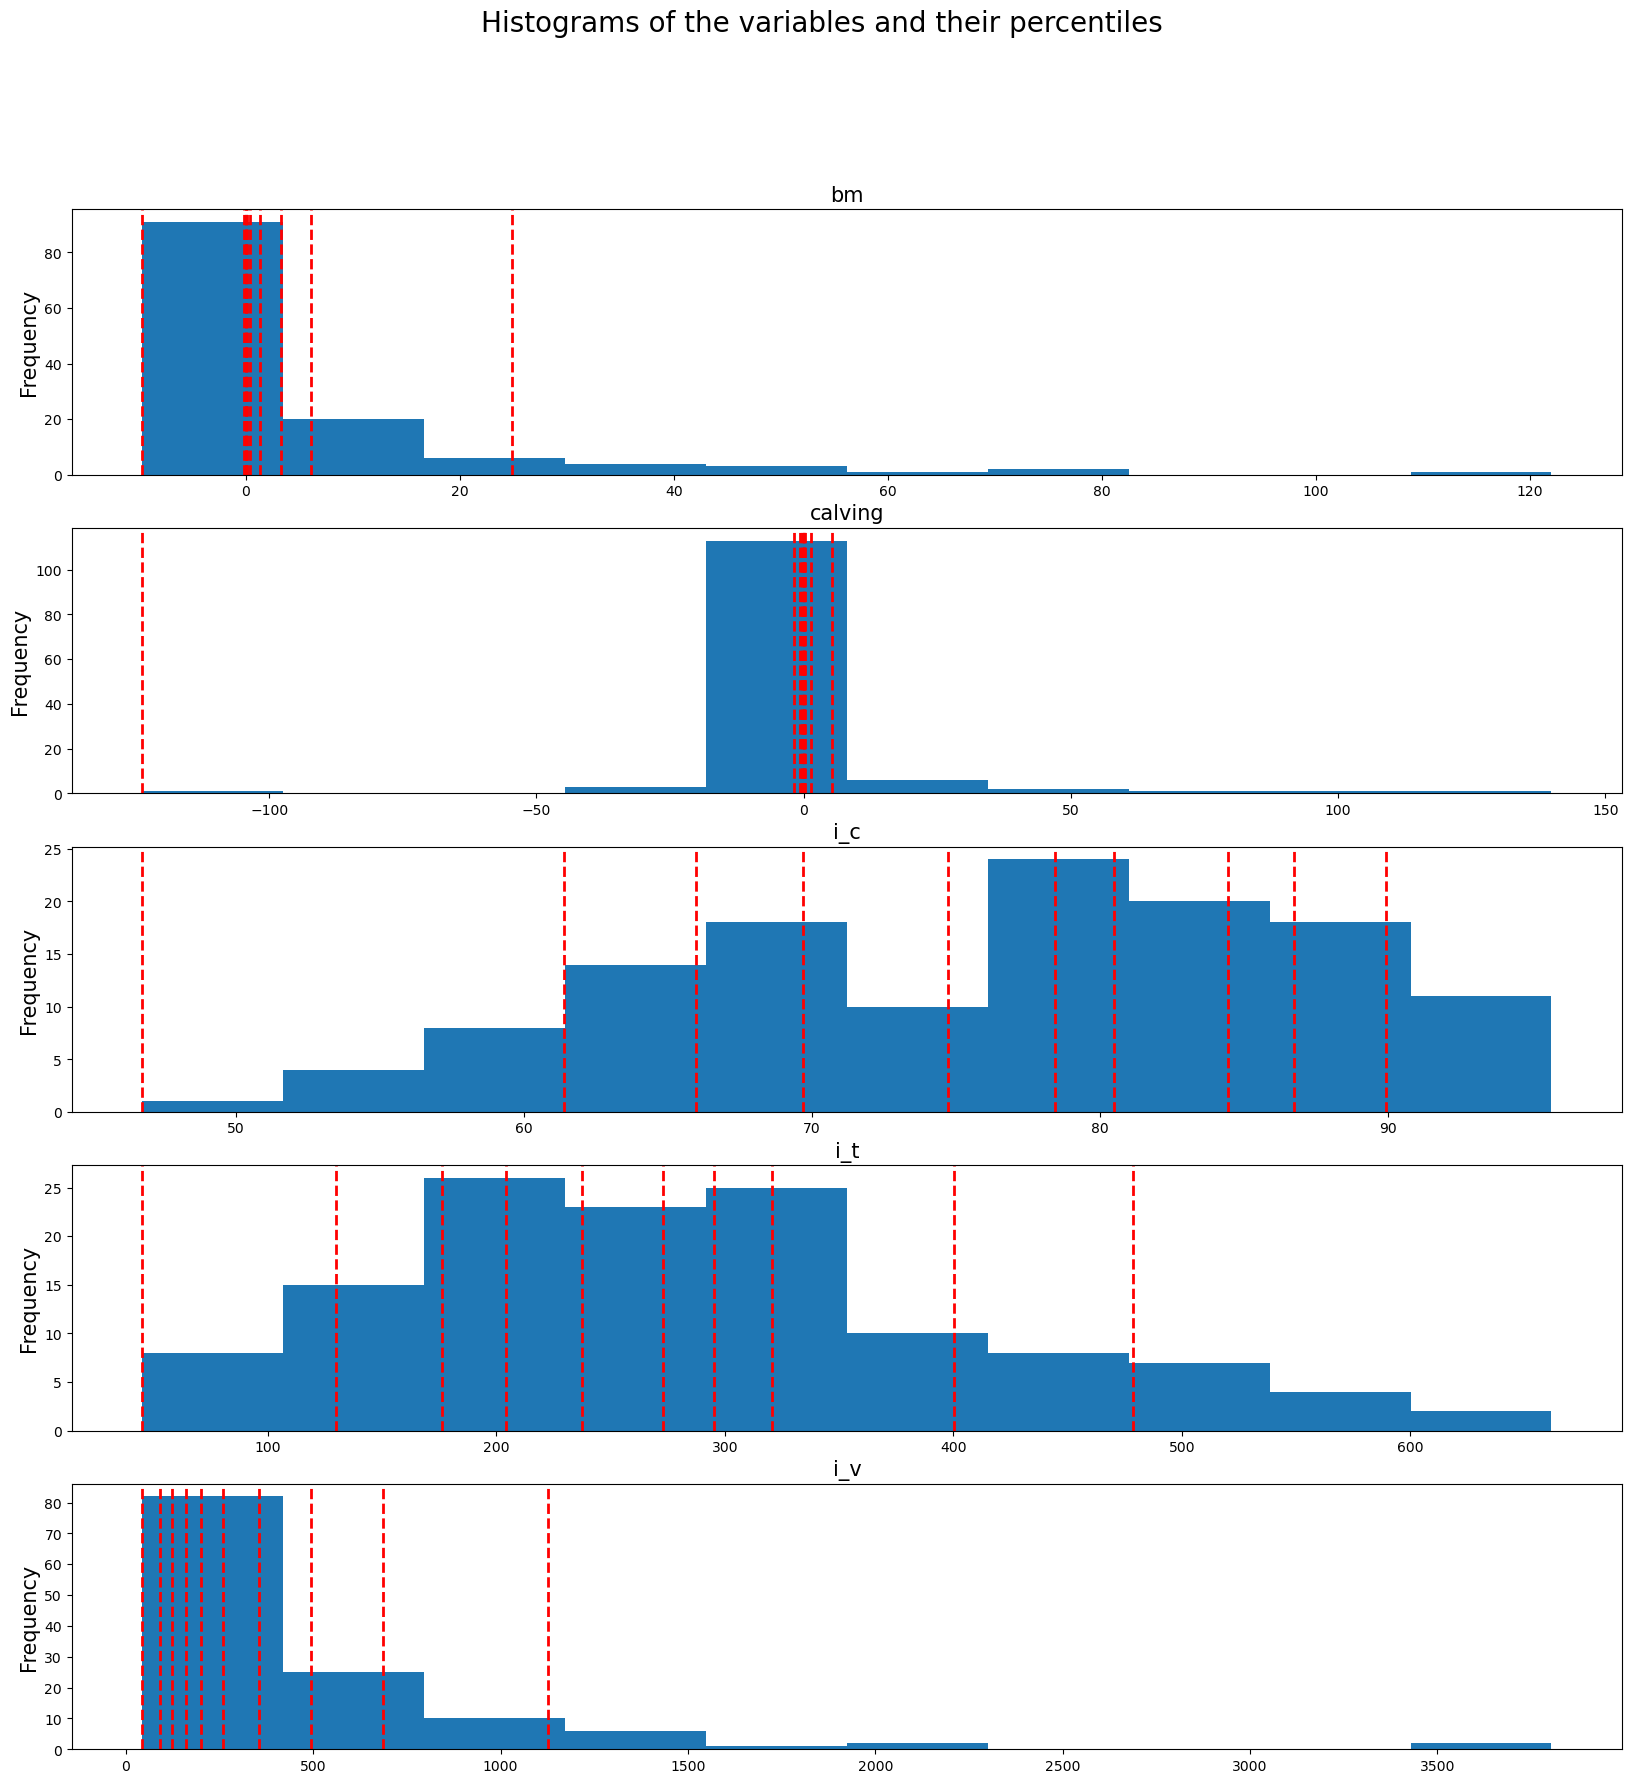

In [8]:
#Calculate the mean for each glacier in time
dataset_mean = dataset.groupby(level=0, axis=1).mean()

#Calculate the percentiles for each variable
percentiles = pd.DataFrame(index=dataset_mean.columns, columns=np.arange(0, 100, 10))

for variable in dataset_mean.columns:
    percentiles.loc[variable] = np.percentile(dataset_mean[variable], np.arange(0, 100, 10))


#plot the histagram for all variables, inclding also the percentiles as lines
fig, axs = plt.subplots(5, 1, figsize=(20, 20))
fig.suptitle('Histograms of the variables and their percentiles', fontsize=20)

for i, variable in enumerate(dataset_mean.columns):
    axs[i].hist(dataset_mean[variable], bins=10)
    axs[i].set_title(variable, fontsize=15)
    axs[i].set_ylabel('Frequency', fontsize=15)
    axs[i].axvline(percentiles.loc[variable, 0], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 10], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 20], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 30], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 40], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 50], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 60], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 70], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 80], color='r', linestyle='dashed', linewidth=2)
    axs[i].axvline(percentiles.loc[variable, 90], color='r', linestyle='dashed', linewidth=2)



In [9]:
#This cell attributes to each glacier mean variable a number from 1 to 10, according to the percentile in which the variable is

glacier_block_ds = pd.DataFrame(index=dataset_mean.index, columns=dataset_mean.columns)

for id in glacier_block_ds.index:
    for variable in glacier_block_ds.columns:
        glacier_block_ds.loc[id, variable] = np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 10], 1,
                                                      np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 20], 2,
                                                               np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 30], 3,
                                                                        np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 40], 4,
                                                                                 np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 50], 5,
                                                                                          np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 60], 6,
                                                                                                   np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 70], 7,
                                                                                                            np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 80], 8,
                                                                                                                     np.where(dataset_mean.loc[id, variable] <= percentiles.loc[variable, 90], 9, 10)))))))))

On the followig block i have the division of the blocks. I divided them (manually) according to the calving percentile, each block contains every range of ice calving percentile. But they seem to be very localised, i will have to check that.

In [10]:
folder_1 = [2,4,6,7,8,15,18,16,34,45,135,163,95]
folder_2 = [3,29,10,12,31,30,19,24,35,50,86,104,139]
folder_3 = [65,43,37,17,41,32,38,40,36,52,143,146,125]
folder_4 = [69,67,63,26,46,33,64,44,70,53,123,145,170]
folder_5 = [75,78,89,39,47,81,77,54,71,55,118,101,117]
folder_6 = [76,80,114,58,48,84,83,66,90,56,140,144,164]
folder_7 = [88,82,120,61,57,92,85,105,100,73,158,124,169]
folder_8 = [96,107,121,62,60,127,87,108,102,91,161,122,160]

folder_9 = [129,112,156,68,97,132,93,109,115,98,148,166] #test
folder_10 = [131,147,157,72,99,136,116,111,119,110,162,159] #test

In [11]:
#Lets split the region dataset according to the blocks

ds_1 = df_region.loc[folder_1]
ds_2 = df_region.loc[folder_2]
ds_3 = df_region.loc[folder_3]
ds_4 = df_region.loc[folder_4]
ds_5 = df_region.loc[folder_5]
ds_6 = df_region.loc[folder_6]
ds_7 = df_region.loc[folder_7]
ds_8 = df_region.loc[folder_8]
ds_9 = df_region.loc[folder_9]
ds_10 = df_region.loc[folder_10]

ds_block = [ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10]

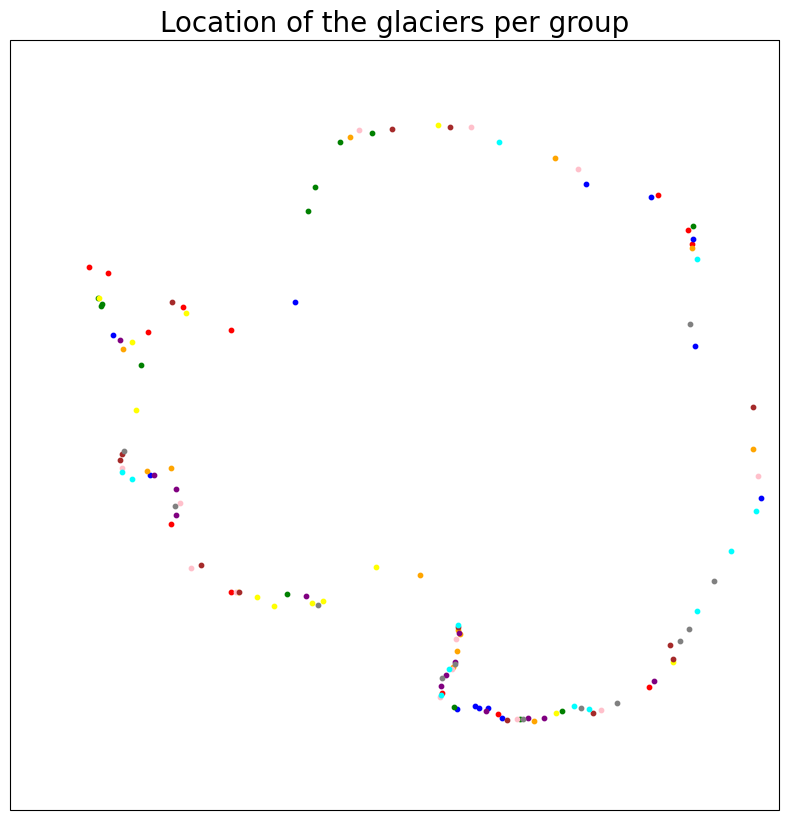

In [12]:
#Plotting the position of the glaciers for each block

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import cartopy.feature

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'aqua']

# Create a plot with a map of Antarctica
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())

# Add coastlines and gridlines
#ax.coastlines()
#ax.gridlines()

# Add land color
#ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='white')
#ax.add_feature(cartopy.feature.OCEAN, edgecolor='blue', facecolor='azure')

i=0
for ds in ds_block:
    for id in ds.index:
        ax.scatter(
            ds['Longitude'].loc[id], ds['Latitude'].loc[id],
            transform=ccrs.PlateCarree(), marker='o', color = colors[i], s = 10
        )
    i+=1

# Add colorbar to the plot

plt.title('Location of the glaciers per group', fontsize=20)
plt.show()



In [13]:
#Splitting dataset accruing to the blocks

block_1 = dataset[dataset.index.isin(folder_1)]
block_2 = dataset[dataset.index.isin(folder_2)]
block_3 = dataset[dataset.index.isin(folder_3)]
block_4 = dataset[dataset.index.isin(folder_4)]
block_5 = dataset[dataset.index.isin(folder_5)]
block_6 = dataset[dataset.index.isin(folder_6)]
block_7 = dataset[dataset.index.isin(folder_7)]
block_8 = dataset[dataset.index.isin(folder_8)]
block_9 = dataset[dataset.index.isin(folder_9)]
block_10 = dataset[dataset.index.isin(folder_10)]

all_blocks = [block_1, block_2, block_3, block_4, block_5, block_6, block_7, block_8, block_9, block_10]


In [15]:
#creating a pdf to see the distribution of the mean of each variable (in time) for each block

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = 'blocks_variables_histograms.pdf'
pdf = PdfPages(pdf_filename)

for variable in dataset_mean.columns:

    num_rows = 2
    num_cols = 5

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle(f'Histograms of the variable ' + variable + ' for each block', fontsize=20)

    i = 0
    for row in range(num_rows):
        for col in range(num_cols):
            block = all_blocks[i]
            ax = axes[row, col]
            color = 'orange' if i + 1 in [9, 10] else 'blue'  # Choose color
            block[variable].mean(axis=1).hist(ax=ax, bins=50, color = color)
            ax.set_title(f'Block ' + str(i + 1))
            i += 1

    for ax in axes.flat:
        ax.set(xlabel=variable, ylabel='Frequency')



    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Add space for the main title

    pdf.savefig(fig)
    
    plt.close()
pdf.close()

print("PDF created.")

PDF created.


In [16]:
#Same of the precedent cell but for all variables (not just mean)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = 'blocks_variables_histograms_all.pdf'
pdf = PdfPages(pdf_filename)

for variable in dataset_mean.columns:

    print(variable)

    num_rows = 2
    num_cols = 5

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle(f'Histograms of the variable ' + variable + ' for each block', fontsize=20)

    i = 0
    for row in range(num_rows):
        for col in range(num_cols):

            block = all_blocks[i]
            ax = axes[row, col]
            color = 'orange' if i + 1 in [9, 10] else 'blue'  # Choose color
            flat = block[variable].values.flatten()

            ax.hist(flat, bins=50, color=color, alpha=0.7)
            ax.set_title(f'Block ' + str(i + 1))
            i += 1


    for ax in axes.flat:
        ax.set(xlabel=variable, ylabel='Frequency')

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Add space for the main title

    pdf.savefig(fig)
    
    plt.close()
pdf.close()

print("PDF created.")

bm
calving
i_c
i_t
i_v
PDF created.


In [ ]:
#In listone i am merging all tthe data related to a particular variable in a single list 
#(for example all gbasal melting tiime series for all glaciers), in order to isualize the distribution

listone = []


for variable in [bm, calving, i_c, i_v, i_t]:

    list_tmp = []

    for year in common_years:
        
        for id in index:

            list_tmp.append(variable.loc[id][str(year)])

    listone.append(list_tmp)


In [ ]:
df = pd.DataFrame(listone).T
df.columns = ['bm', 'calving', 'i_c', 'i_v', 'i_t']


Text(0, 0.5, 'Frequency')

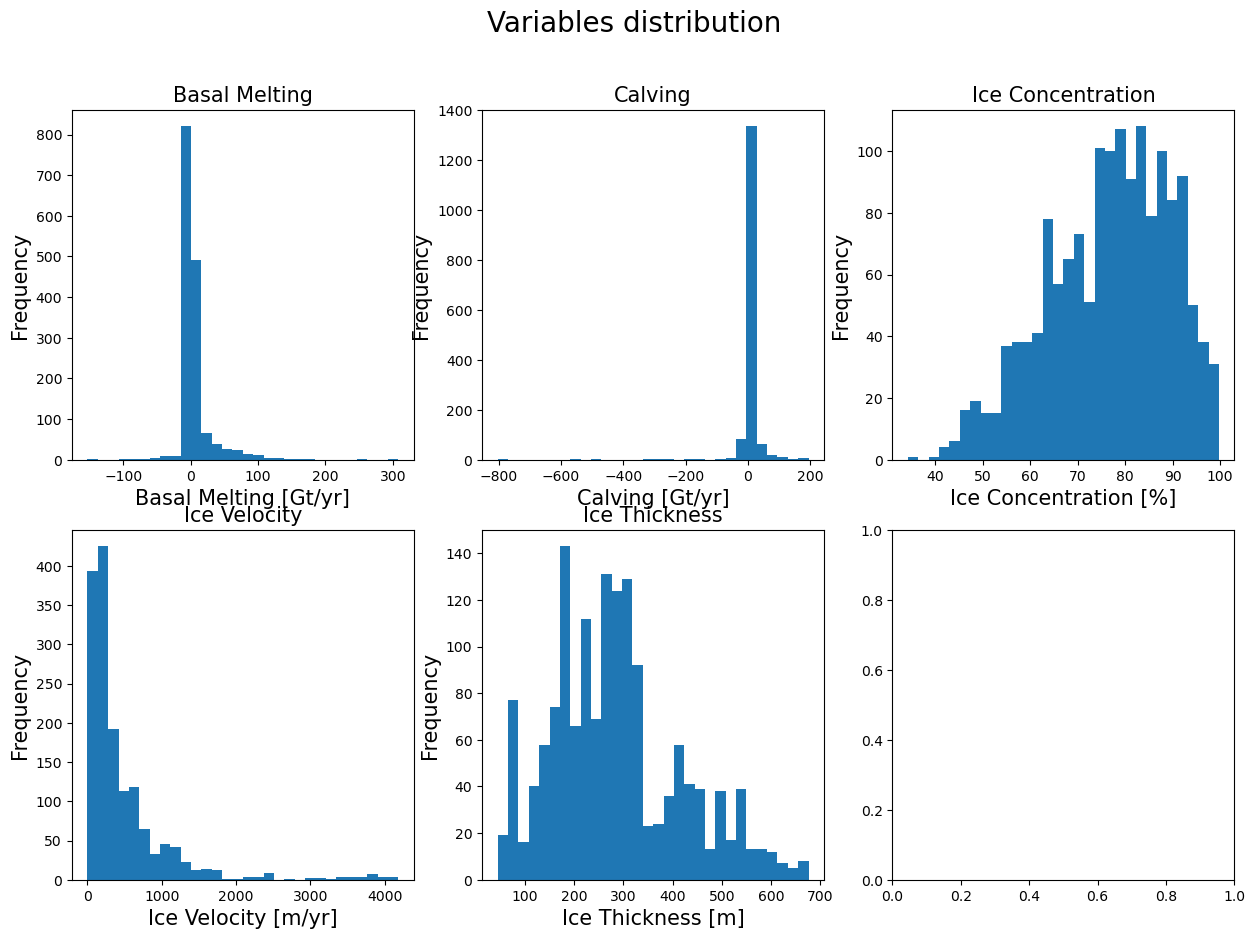

In [ ]:
#Plot each single variable in a multi multi figure plot, which has 2 rows and 3 columns
fig, axs = plt.subplots(2,3, figsize=(15,10))
fig.suptitle('Variables distribution', fontsize=20)

#Plot the basal melting
axs[0,0].hist(df['bm'], bins=30)
axs[0,0].set_title('Basal Melting', fontsize=15)
axs[0,0].set_xlabel('Basal Melting [Gt/yr]', fontsize=15)
axs[0,0].set_ylabel('Frequency', fontsize=15)

#Plot the calving
axs[0,1].hist(df['calving'], bins=30)
axs[0,1].set_title('Calving', fontsize=15)
axs[0,1].set_xlabel('Calving [Gt/yr]', fontsize=15)
axs[0,1].set_ylabel('Frequency', fontsize=15)

#Plot the ice concentration
axs[0,2].hist(df['i_c'], bins=30)
axs[0,2].set_title('Ice Concentration', fontsize=15)
axs[0,2].set_xlabel('Ice Concentration [%]', fontsize=15)
axs[0,2].set_ylabel('Frequency', fontsize=15)

#Plot the ice velocity
axs[1,0].hist(df['i_v'], bins=30)
axs[1,0].set_title('Ice Velocity', fontsize=15)
axs[1,0].set_xlabel('Ice Velocity [m/yr]', fontsize=15)
axs[1,0].set_ylabel('Frequency', fontsize=15)

#Plot the ice thickness
axs[1,1].hist(df['i_t'], bins=30)
axs[1,1].set_title('Ice Thickness', fontsize=15)
axs[1,1].set_xlabel('Ice Thickness [m]', fontsize=15)
axs[1,1].set_ylabel('Frequency', fontsize=15)


